### Main objectives of notebook 

- Demonstrating the time series filters used during preprocessing

We import the necessary libraries; this requires the poetry environment to be set up, and set default plotting commands

In [1]:
import boto3
import awswrangler as wr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.impute import KNNImputer
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import extract_features, feature_extraction
from scipy.signal import savgol_filter, medfilt
from src.dataloader import DataLoader
from src.config import PATHS, KEYS

style_sheet = PATHS.MISC_DIR / "base.mplstyle"
plt.style.use(style_sheet)

Connect to AWS Athena and query data

In [2]:
TRAINING_QUERY = f"""
    SELECT
        *,
        case when uuid like '%_walk_%' then true else false end as target
    FROM
        "smu-iot"."microbit"
    WHERE
        seconds IS NOT null
      AND uuid IN ('clarence_walk_1', 'licheng_situps_1', 'luna_ankle', 'luna_collar', 
                   'sinhong_walk_1', 'songhan_bagstroll_1', 'licheng_situps_1', 'licheng_walk_1', 
                   'licheng_dynamic_1', 'licheng_shaking_1', 'licheng_box_1', 'songhan_walk_1', 
                   'songhan_walk_2', 'spencer_walk_1', 'licheng_walk_2', 'songhan_fan_1')
    ORDER BY
        uuid, timestamp, seconds
"""

The data is loaded in by calling a `DataLoader` class, which loads our activity data into a suitable structure, and invoking the `.load_data()` method.

In [3]:
session = boto3.setup_default_session(
    region_name=KEYS.AWS_DEFAULT_REGION,
    aws_access_key_id=KEYS.AWS_ACCESS_KEY_ID,
    aws_secret_access_key=KEYS.AWS_SECRET_ACCESS_KEY,
)

dataloader = DataLoader(session=session)

df = dataloader.load_data(TRAINING_QUERY, "smu-iot")

We can set up a quick function to apply a smoothing filter on our data

In [4]:
def smooth_filter(
    df: pd.DataFrame, 
    cols: list,
    apply_median: bool = True,
    apply_sg: bool = True,
    **kwargs,
) -> pd.DataFrame:
    """
    Args:
        df: Pandas series
        cols: DataFrame columns
    
    Returns:
        Pandas DataFrame with smoothed time series 
    """
        
    new_cols = [c + '_post' for c in cols]
    df[new_cols] = np.nan
    window_length = kwargs['window_length']
    window_n = kwargs['window_n']
    ts_id = 0
        
    for item in df.uuid.unique():
        start_idx = df.query(f"uuid == '{item}'").index[0]
        end_idx = df.query(f"uuid == '{item}'").index[-1]
        for idx in range(start_idx, end_idx, window_n):
            if apply_median:
                df.loc[idx:min(idx + window_n - 1,end_idx), new_cols] = \
                df.loc[idx:min(idx + window_n - 1,end_idx), cols].apply(medfilt, axis=0).values
            if apply_sg:
                window_length = min(min(idx + window_n - 1,end_idx) - idx, window_length)
                polyorder = window_length // 2
                df.loc[idx:min(idx + window_n - 1,end_idx), new_cols] = \
                df.loc[idx:min(idx + window_n - 1,end_idx), cols].apply(savgol_filter, window_length=window_length, 
                                                                        polyorder=polyorder, axis=0).values
            df.loc[idx:min(idx + window_n - 1,end_idx), 'ts_id'] = ts_id
            ts_id += 1
                
    return df

Along with defining our base features

In [5]:
quantitative_vars = [
    'accel_x',
    'gyro_x',
    'accel_y',
    'gyro_y',
    'accel_z',
    'gyro_z'
]

We first load in a `KNNImputer` to impute missing values

In [6]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df[quantitative_vars] = imputer.fit_transform(df[quantitative_vars])

We can then smooth the signal for further processing

In [7]:
smoothed_data = smooth_filter(
    df, 
    quantitative_vars, 
    apply_median=True, 
    apply_sg=False, 
    window_length=20, 
    window_n=4
)

kernel_size exceeds volume extent: the volume will be zero-padded.


In [8]:
#special handling for bag walking
smoothed_data.loc[smoothed_data.uuid == 'songhan_bagstroll_1', 'target'] = True

# define processed_cols for further feature extraction
processed_cols = [f"{c}_post" for c in quantitative_vars]

Step counting can be framed as the counting of peaks of the processed variables

In [9]:
for c in processed_cols:
    print(c, feature_extraction.feature_calculators.number_peaks(smoothed_data.query("uuid == 'songhan_bagstroll_1'")[200:400][c], 5))

accel_x_post 13
gyro_x_post 1
accel_y_post 6
gyro_y_post 0
accel_z_post 5
gyro_z_post 0


The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Next, we run our smoothed data through `extract_features` from `TSFresh`

In [10]:
features = extract_features(smoothed_data[['seconds', 'ts_id', *processed_cols]], column_id="ts_id", column_sort="seconds").dropna(axis=1)

Feature Extraction: 100%|██████████| 20/20 [07:02<00:00, 21.14s/it]


After joining the features on the `ts_id`, we can then run a relevance table calculation

In [17]:
feature_columns = features.columns.values
post_processed_data = smoothed_data.groupby(["ts_id"]).max().join(features, on=["ts_id"])
X_train, y_train = post_processed_data[feature_columns], post_processed_data["target"]
relevant_features_tb = calculate_relevance_table(X_train, y_train)

This list provides a useful starting point to decide on which features to keep

In [18]:
print(relevant_features_tb.loc[relevant_features_tb["relevant"] == True, "feature"])

feature
accel_y_post__sum_values                                                                             accel_y_post__sum_values
accel_x_post__sum_of_reoccurring_values                                               accel_x_post__sum_of_reoccurring_values
accel_x_post__sum_of_reoccurring_data_points                                     accel_x_post__sum_of_reoccurring_data_points
accel_x_post__maximum                                                                                   accel_x_post__maximum
accel_x_post__absolute_maximum                                                                 accel_x_post__absolute_maximum
                                                                                                  ...                        
gyro_z_post__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0    gyro_z_post__change_quantiles__f_agg_"mean"__i...
gyro_z_post__large_standard_deviation__r_0.45                                   gyro_z_post__large_standard_de

An alternative approach is to calculate feature importance using the `shap` library

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


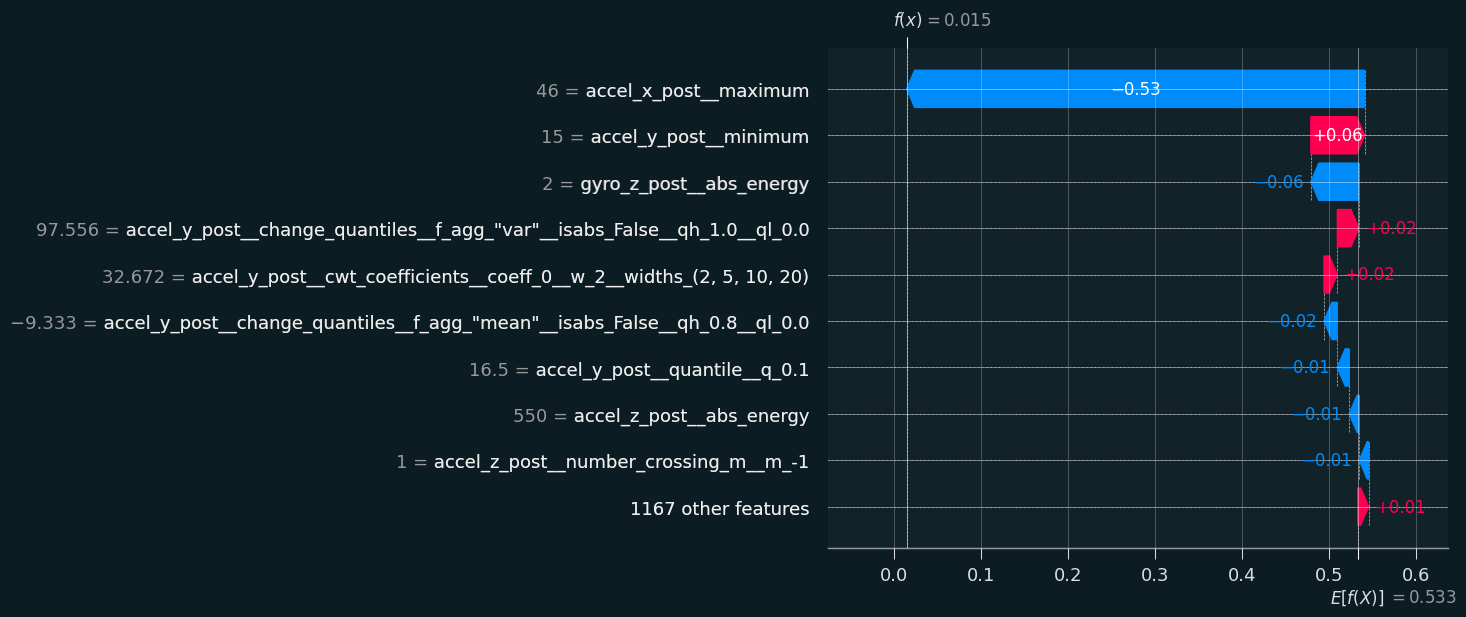

In [19]:
# train an XGBoost model
model = xgb.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[-1])

We can also summarise the effects of all the features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


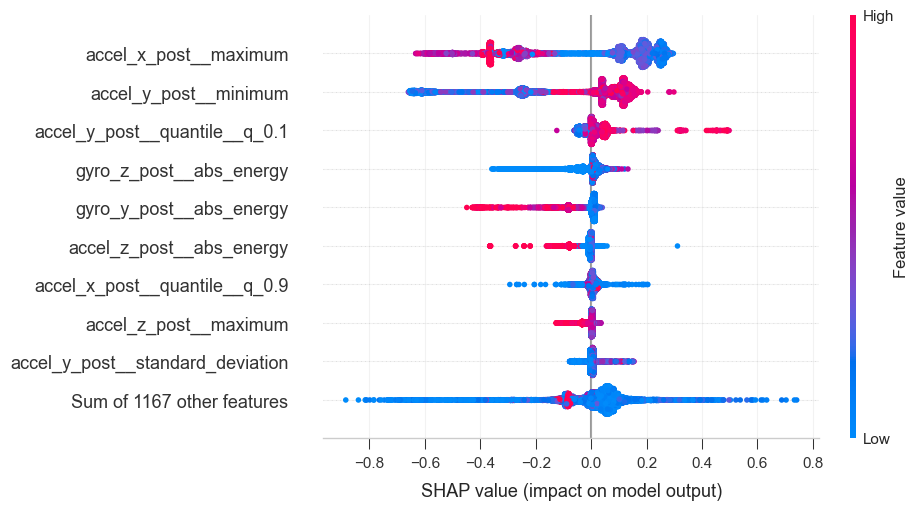

In [24]:
sns.set_style("whitegrid")
shap.plots.beeswarm(shap_values)

We can cut down the number of features to a set size programmatically

In [21]:
df_shap_values = pd.DataFrame(data=shap_values.values, columns=X_train.columns)
df_feature_importance = pd.DataFrame(columns=['feature', 'importance'])

for col in df_shap_values.columns:
    importance = df_shap_values[col].abs().mean()
    df_feature_importance.loc[len(df_feature_importance)] = [col,importance]
    
df_feature_importance = df_feature_importance.sort_values('importance', ascending=False)

In [22]:
print(df_feature_importance.loc[:50, "feature"])

810                                 accel_x_post__maximum
28                                  accel_y_post__minimum
76                          accel_y_post__quantile__q_0.1
593                               gyro_z_post__abs_energy
201                               gyro_y_post__abs_energy
                              ...                        
1011    gyro_x_post__time_reversal_asymmetry_statistic...
51      accel_y_post__symmetry_looking__r_0.7000000000...
1013                               gyro_x_post__c3__lag_2
1014                               gyro_x_post__c3__lag_3
50                 accel_y_post__symmetry_looking__r_0.65
Name: feature, Length: 769, dtype: object
